# DNN Classification

In [217]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from labm8 import fs
from labm8 import viz

from keras.models import Sequential
from keras.layers import Input, Dropout, Embedding, merge, LSTM, Dense
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import percentileofscore

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

import clgen
from clgen import clutil
from clgen.atomizer import CharacterAtomizer, GreedyAtomizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
seed = 7
np.random.seed(seed)

Methods for wrangling data:

In [219]:
def get_features(D):
    """ return np array of shape (len(D), nb_features)"""
    return np.array([
#         D["comp"].values,
#         D["rational"].values,
#         D["mem"].values,
#         D["localmem"].values,
#         D["coalesced"].values,
#         D["transfer"].values,
#         D["wgsize"].values,
        (D["transfer"].values / (D["comp"].values + D["mem"].values)),  # F1
        (D["coalesced"].values / D["mem"].values),  # F2
        ((D["localmem"].values / D["mem"].values) * D["wgsize"].values),  # F3
        (D["comp"].values / D["mem"].values),  # F4
    ]).T


def get_dynprops(D):
    """ return np array of shape (len(D), 2) """
    return np.array([
        D["transfer"].values,
        D["wgsize"].values
    ]).T


def get_sequences(D, maxlen):
    """ return np array of shape (len(D), maxlen) """
    for row in D["seq"].values:
        assert(len(row) == maxlen)
    data = np.array(D["seq"].values)
    return np.vstack([np.expand_dims(x, axis=0) for x in data])


def get_labels(D):
    """ cpu/gpu to int, return np array of shape (len(D), 1) """
    return np.vstack([np.expand_dims(x, axis=0) for x in D["oracle_enc"]])


def get_train_validation_test_splits(D, split=(.6, .2, .2), seed=1):
    """ split dataframe into 3 frames for training, validation, and testing """
    assert(sum(split) == 1.0)
    train_split, validation_split, test_split = split
    
    num_synthetic = sum(D["synthetic_enc"].values)
    print(num_synthetic)
    
    np.random.seed(seed)
    train_msk = np.random.rand(len(D)) < train_split
    
    train = D[train_msk]
    other = D[~train_msk]
    
    test_msk = np.random.rand(len(other)) < split[2] / sum(split[1:])
    test = other[test_msk]
    validation = other[~test_msk]
 
    np.random.seed()  # re-seed RNG
    return train, validation, test

Load dataset:

In [220]:
def load_dataframe(platform, use_synthetic=False, maxlen=1000, atomizer=CharacterAtomizer):
    """ load experimental results """
    def escape_suite_name(g):
        """format benchmark suite name for display"""
        c = g.split('-')
        if (c[0] == "amd" or c[0] == "npb" or c[0] == "nvidia" or c[0] == "shoc"):
            return c[0].upper()
        else:
            return c[0].capitalize()
    
    if use_synthetic:    
        B = pd.read_csv(fs.path("classification/{platform}-benchmarks.csv".format(**vars())))
        B["synthetic"] = [escape_suite_name(x) for x in B["benchmark"]]
        B["synthetic_enc"] = [0] * len(B)

        S = pd.read_csv(fs.path("classification/{platform}-clgen.csv".format(**vars())))
        S["synthetic"] = ["CLgen"] * len(S)
        S["synthetic_enc"] = [1] * len(S)

        dataframe = pd.concat((B, S))
    else:
        dataframe = pd.read_csv(fs.path("classification/{platform}-benchmarks.csv".format(**vars())))
        dataframe["synthetic"] = escape_suite_name(x) for x in B["benchmark"]
        dataframe["synthetic_enc"] = [0] * len(dataframe)

    print("num instances {} ({} synthetic, {} benchmarks)".format(
        len(dataframe),
        sum(dataframe["synthetic_enc"].values),
        len(dataframe) - sum(dataframe["synthetic_enc"].values)))
        
    dataframe["oracle_enc"] = [1 if x == "GPU" else 0 for x in dataframe["oracle"].values]

    # load source code:
    source_dir = fs.path("classification/kernels")
    srcs = []
    for row in dataframe["benchmark"].values:
        inpath = fs.path(source_dir, row + ".cl")
        with open(inpath) as infile:
            src = infile.read()
        srcs.append(src)
        
    print("unique kernels", len(set(srcs)))
    dataframe["src"] = srcs
    dataframe["src_len"] = [len(s) for s in srcs]
    
    # encode and pad sequences:
    atomizer = atomizer.from_text(''.join(dataframe["src"].values))
    
    seqs = [atomizer.atomize(seq) for seq in dataframe["src"].values]
    seq_length = min(max(len(s) for s in seqs), maxlen)
    pad_val = atomizer.vocab_size + 1
    dataframe["seq_len"] = [len(s) for s in seqs]
    dataframe["seq"] = list(pad_sequences(seqs, maxlen=seq_length, value=pad_val))
    print("vocab size", atomizer.vocab_size)
    print("pad val", pad_val)
    print("seq length", seq_length)
    
    return dataframe, seq_length

dataframe, seq_length = load_dataframe(
    platform="nvidia", 
    maxlen=512, 
    use_synthetic=False, 
    atomizer=GreedyAtomizer
)

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 134
pad val 135
seq length 512


Features and labels for training:

In [221]:
def get_train_validation_test_splits(D, split=(.6, .2, .2), seed=1):
    """ split dataframe into 3 frames for training, validation, and testing.
    synthetics are exclusively for training """
    # TODO: balance benchmark suites in splits
    # TODO: balance labels in splits
    assert(sum(split) == 1.0)
    train_split, validation_split, test_split = split
    
    num_synthetic = sum(D["synthetic_enc"].values)
    num_benchmarks = len(D) - num_synthetic
    
    np.random.seed(seed)
    train_msk = np.logical_or(np.random.rand(len(D)) < train_split, D["synthetic_enc"])
    
    train = D[train_msk]
    other = D[~train_msk]
    
    test_msk = np.random.rand(len(other)) < split[2] / sum(split[1:])
    test = other[test_msk]
    validation = other[~test_msk]

    np.random.seed()  # re-seed RNG
    return train, validation, test

train, validation, test = get_train_validation_test_splits(dataframe)

x_train_a = get_features(train)
x_train_dynprop = get_dynprops(train)
x_train_b = get_sequences(train, seq_length)
y_train = get_labels(train)

x_val_a = get_features(validation)
x_val_dynprop = get_dynprops(validation)
x_val_b = get_sequences(validation, seq_length)
y_val = get_labels(validation)

x_test_a = get_features(test)
x_test_dynprop = get_dynprops(test)
x_test_b = get_sequences(test, seq_length)
y_test = get_labels(test)

num_features = len(x_train_a[0])
num_dynprop = len(x_train_dynprop[0])
num_classes = len(np.unique(y_train))
seq_length = len(x_train_b[0])
vocab_size = atomizer.vocab_size + 1  # +1 for pad value

print("num features", num_features)
print("num dynprops", num_dynprop)
print("num tokens", vocab_size)
print("seq length", seq_length)
print("num classes", num_classes)
print("num instances", len(dataframe))

num features 4
num dynprops 2
num tokens 87
seq length 512
num classes 2
num instances 680


## Dataset exploration

Accuracy of Zero-R (GPU): 56.91%


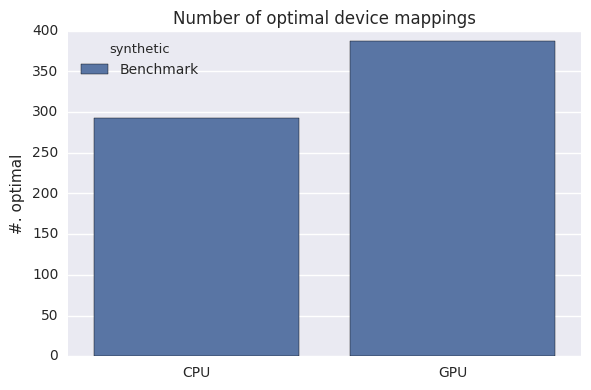

In [222]:
ax = sns.countplot(x="oracle_enc", data=dataframe, hue="synthetic")
plt.title("Number of optimal device mappings")
plt.xticks([0, 1], ["CPU", "GPU"])
plt.xlabel("")
plt.ylabel("#. optimal")

num_oracle_gpu = sum(dataframe["oracle_enc"])
num_oracle_cpu = len(dataframe) - num_oracle_gpu
zero_r = "CPU" if num_oracle_cpu > num_oracle_gpu else "GPU"
acc_zero_r = max(num_oracle_cpu, num_oracle_gpu) / len(dataframe)

print("Accuracy of Zero-R ({zero_r}): {acc_zero_r:.2%}".format(**vars()))

viz.finalise(figsize=(6, 4))

min seq len 53
max seq len 24604
mean seq len 2652
25% percentile 295
50% percentile 538
60% percentile 730
75% percentile 1536
90% percentile 13449
percentile of padded seq len 47.6%


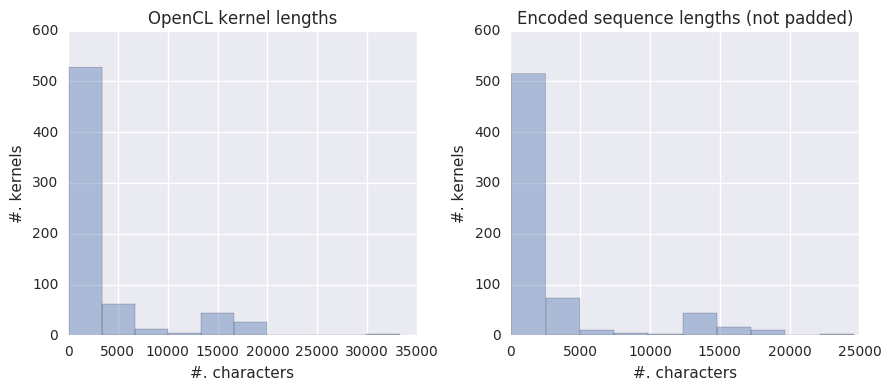

In [223]:
plt.subplot(1, 2, 1)
ax = sns.distplot(dataframe["src_len"], kde=None, bins=10)
plt.title("OpenCL kernel lengths")
plt.xlabel("#. characters")
plt.ylabel("#. kernels")

plt.subplot(1, 2, 2)
ax = sns.distplot(dataframe["seq_len"], kde=None, bins=10)
plt.title("Encoded sequence lengths (not padded)")
plt.xlabel("#. characters")
plt.ylabel("#. kernels")


print("min seq len", min(dataframe["seq_len"]))
print("max seq len", max(dataframe["seq_len"]))
print("mean seq len", int(round(np.mean(dataframe["seq_len"]))))
for p in [25, 50, 60, 75, 90]:
    print("{p}% percentile".format(p=p), int(np.percentile(dataframe["seq_len"], p)))
print("percentile of padded seq len {:.1f}%".format(
    percentileofscore(dataframe["seq_len"], seq_length, 'mean')))

viz.finalise(figsize=(9, 4))

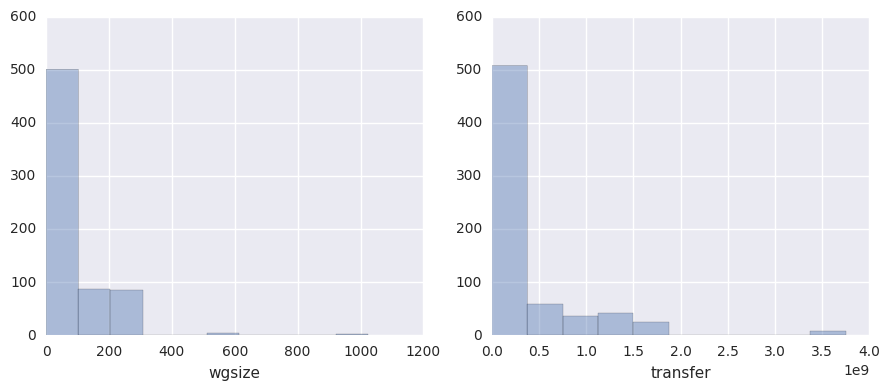

In [224]:
plt.subplot(1, 2, 1)
ax = sns.distplot(dataframe["wgsize"], kde=None, bins=10)
plt.subplot(1, 2, 2)
ax = sns.distplot(dataframe["transfer"], kde=None, bins=10)
viz.finalise(figsize=(9, 4))

## Source + dynamic props classification

### CGO'13 model

In [225]:
clf = DecisionTreeClassifier(random_state=seed, splitter="best", criterion="entropy")
clf.fit(x_train_a, y_train)

clf_score = clf.score(x_test_a, y_test)
print("Accuracy on test data: {:.2%}".format(clf_score))

Accuracy on test data: 83.45%


### Baseline model (extracted features)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dynprop_norm (BatchNormalization (None, 4)             16          batchnormalization_input_14[0][0]
____________________________________________________________________________________________________
dense_21 (Dense)                 (None, 16)            80          dynprop_norm[0][0]               
____________________________________________________________________________________________________
output (Dense)                   (None, 1)             17          dense_21[0][0]                   
Total params: 113
Trainable params: 105
Non-trainable params: 8
____________________________________________________________________________________________________


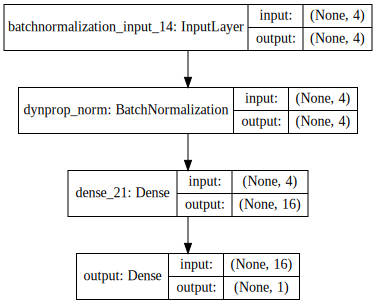

In [159]:
baseline = Sequential()
baseline.add(BatchNormalization(input_shape=(num_features,), name="dynprop_norm"))
baseline.add(Dense(16, input_dim=num_features, activation="relu"))
baseline.add(Dense(1, activation='sigmoid', name="output"))

baseline.compile(loss='binary_crossentropy',
                 optimizer='rmsprop',
                 metrics=['accuracy'])
baseline.summary()

SVG(model_to_dot(baseline, show_shapes=True).create(prog='dot', format='svg'))

In [160]:
np.random.seed(seed)
baseline.fit(x_train_a, y_train,
             nb_epoch=5,
             validation_data=(x_val_a, y_val),
             verbose=1)

baseline_scores = baseline.evaluate(x_test_a, y_test, verbose=0)
print("Accuracy on test data: {:.2%}".format(baseline_scores[1]))

Train on 404 samples, validate on 131 samples
Epoch 1/5
404/404 [==============================] - 0s - loss: 0.7083 - acc: 0.5693 - val_loss: 0.8840 - val_acc: 0.5725
Epoch 2/5
404/404 [==============================] - 0s - loss: 0.6943 - acc: 0.6040 - val_loss: 0.7960 - val_acc: 0.5725
Epoch 3/5
404/404 [==============================] - 0s - loss: 0.6853 - acc: 0.6040 - val_loss: 0.7583 - val_acc: 0.5725
Epoch 4/5
404/404 [==============================] - 0s - loss: 0.6786 - acc: 0.6015 - val_loss: 0.7354 - val_acc: 0.5954
Epoch 5/5
404/404 [======================

### Baseline with only dynamic props

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dynprop_norm (BatchNormalization (None, 2)             8           batchnormalization_input_15[0][0]
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 32)            96          dynprop_norm[0][0]               
____________________________________________________________________________________________________
output (Dense)                   (None, 1)             33          dense_22[0][0]                   
Total params: 137
Trainable params: 133
Non-trainable params: 4
____________________________________________________________________________________________________


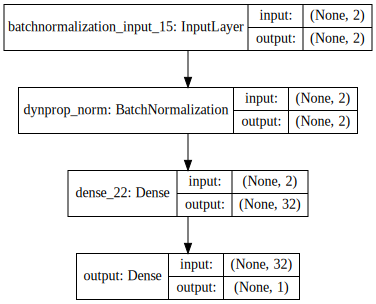

In [161]:
baseline_b = Sequential()
baseline_b.add(BatchNormalization(input_shape=(num_dynprop,), name="dynprop_norm"))
baseline_b.add(Dense(32, input_dim=num_dynprop, activation="relu"))
baseline_b.add(Dense(1, activation='sigmoid', name="output"))

baseline_b.compile(loss='binary_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])
baseline_b.summary()

SVG(model_to_dot(baseline_b, show_shapes=True).create(prog='dot', format='svg'))

In [162]:
np.random.seed(seed)
baseline_b.fit(x_train_dynprop, y_train,
               nb_epoch=5,
               validation_data=(x_val_dynprop, y_val),
               verbose=1)

baseline_b_scores = baseline_b.evaluate(x_test_dynprop, y_test, verbose=0)
print("Test on {} samples: {:.2%}".format(len(y_test), baseline_b_scores[1]))

Train on 404 samples, validate on 131 samples
Epoch 1/5
404/404 [==============================] - 0s - loss: 0.6900 - acc: 0.5743 - val_loss: 0.7787 - val_acc: 0.5954
Epoch 2/5
404/404 [==============================] - 0s - loss: 0.6857 - acc: 0.5743 - val_loss: 0.7388 - val_acc: 0.5954
Epoch 3/5
404/404 [==============================] - 0s - loss: 0.6831 - acc: 0.5743 - val_loss: 0.7292 - val_acc: 0.5954
Epoch 4/5
404/404 [==============================] - 0s - loss: 0.6853 - acc: 0.5743 - val_loss: 0.7233 - val_acc: 0.5954
Epoch 5/5
404/404 [======================

### Baseline with only source

In [237]:
# embedding_vector_length = 32

# baseline_c = Sequential()
# baseline_c.add(Embedding(vocab_size, embedding_vector_length, input_length=seq_length))
# baseline_c.add(LSTM(32, input_dim=embedding_vector_length, input_length=seq_length))
# baseline_c.add(Dense(1, activation='sigmoid'))

# baseline_c.compile(loss='binary_crossentropy',
#                    optimizer='adam',
#                    metrics=['accuracy'])

# baseline_c.summary()

# SVG(model_to_dot(baseline_c, show_shapes=True).create(prog='dot', format='svg'))

In [164]:
# np.random.seed(seed)
# baseline_c.fit(x_train_b, y_train,
#                batch_size=64, nb_epoch=10,
#                validation_data=(x_val_b, y_val),
#                verbose=1)

# scores = model.evaluate(x_test_b, y_test, verbose=0)
# print("Accuracy: {:.2%}".format(scores[1]))

### Multi-input model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
seq_in (InputLayer)              (None, 512)           0                                            
____________________________________________________________________________________________________
embedding_28 (Embedding)         (None, 512, 64)       5568        seq_in[0][0]                     
____________________________________________________________________________________________________
dynprop_in (InputLayer)          (None, 2)             0                                            
____________________________________________________________________________________________________
lstm_32 (LSTM)                   (None, 32)            12416       embedding_28[0][0]               
___________________________________________________________________________________________

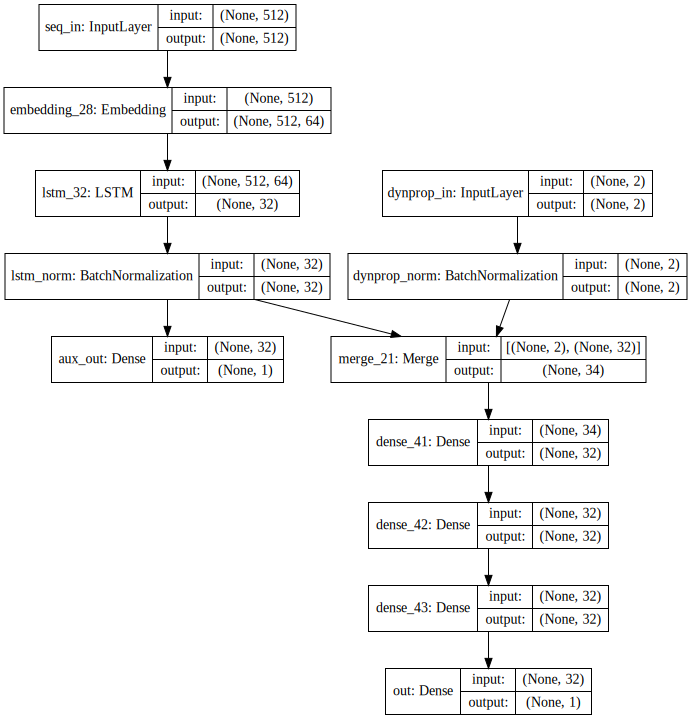

In [235]:
embedding_vector_length = 64 # 64

# TODO: batch norm after merge, not before
# TODO: another layer of LSTM
# TODO: Dropout?
# TODO: activations: rely, sigmoid, softmax

dyn_inputs = Input(shape=(num_dynprop,), name="dynprop_in")
left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

seq_inputs = Input(shape=(seq_length,), dtype="int32", name="seq_in")
right = Embedding(output_dim=embedding_vector_length, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
# right = LSTM(32, consume_less="mem", return_sequences=True)(right)
# right = Dropout(.2)(right)
right = LSTM(32, consume_less="mem")(right)
right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

aux_out = Dense(1, activation="sigmoid", name="aux_out")(right)

x = merge([left, right], mode="concat")
x = Dense(32, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(32, activation="relu")(x)
out = Dense(1, activation="sigmoid", name="out")(x)

model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])

model.compile(optimizer="rmsprop", # adam
              loss={"out": "binary_crossentropy", "aux_out": "binary_crossentropy"},
              loss_weights={"out": 1., "aux_out": .2})

model.summary()

model_to_dot(model, show_shapes=True).write("model.dot")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [236]:
batch_size = 3

np.random.seed(seed)
start = time.time()
# if we run out of memory, try reducing the batch size. this will slow down training
model.fit({"dynprop_in": x_train_dynprop, "seq_in": x_train_b},
          {"out": y_train, "aux_out": y_train},
          nb_epoch=10, # 50,
          batch_size=batch_size, # 32
          validation_data=({"dynprop_in": x_val_dynprop, "seq_in": x_val_b}, {"out": y_val, "aux_out": y_val}),
          verbose=1,
          shuffle=True
)
print("training time {:.2f}s".format(time.time() - start))

start = time.time()
scores = model.evaluate({"dynprop_in": x_test_dynprop, "seq_in": x_test_b},
                        {"out": y_test, "aux_out": y_test}, batch_size=batch_size, verbose=0)
print("evaluation time {:.2f}s".format(time.time() - start))
print("Test on {} samples: {:.2%}".format(len(y_test), baseline_b_scores[1]))

Train on 404 samples, validate on 131 samples
Epoch 1/10
404/404 [==============================] - 116s - loss: 0.7870 - out_loss: 0.6575 - aux_out_loss: 0.6476 - val_loss: 0.8445 - val_out_loss: 0.7117 - val_aux_out_loss: 0.6644

In [173]:
# save or load model:
model.save("model.h5")
# model = load_model('model.h5')

In [ ]:
def eval(create_model, train_fn, save_fn, test_fn, seed=1, save_fn=None, n=5):
    """
    Arguments:
        create_model (function): Function with definition:
                create_model(seed, i) -> model
        train_fn (function): Function with definition:
                train_fn(seed, model, train_data) -> {"time": float}
        save_fn (function): Function with definition:
                save_fn(seed, i, model) -> None
        test_fn (function): Function with definition:
                test_fn(seed, model, test_data) -> {"time": float, "accuracy": float}
        n (int): Number of repetitions
    
    Returns:
        list: list of length n, each element a pair of train_fn(), test_fn() return values
    """
    train_results = []
    test_results = []
    for i in range(seed, seed+n):
        # get training_data
        train, validation, test = get_training_data(seed)
        # create model
        model = create_model(seed, i)
        # train model
        train_result = train_fn(seed, model, train)
        train_results.append(train_result)
        # save model
        save_fn(seed, i, model)
        # make predictions
        test_result = test_fn(seed, model, test_data)
        test_results.append(test_result)
        
    return train_results, test_results